- 삼성전자 주식 다음달 가격 얼마일까?(회귀)
- 비트코인 다음 달 어떻게 될까?(회귀)
-  전날 비트 코인 상승하면 다음날 주가와의 상관관계(correlation)

1. 목표
    1. Y : 미래 30일의 국내 특정 주식과 비트코인의 종가
    1. X : 최근 60일간의 데이터
        1. step : 하루 간격
        1. 양 : 1년(2018년 6월~2019년 6월 말)
2. 데이터 획득
    1. 국내 기업 1개, 비트 코인
3. 데이터 정제
    1. 누락
4. 데이터 전처리
    1. 특수기호, 문자 > 수치 변환
    1. 두 데이터 날짜 기준으로 통합(axis=1)
        1. 외국(2018-01-01), 국내(2018.1.1),(18.1.1)
        1. 날짜 포맷을 (YYYY-MM-DD) 으로 변환 후 통합
1. 비트코인 가격 변화와 주가와의 상관관계(correlation)
    1. cov()
5. 입력X/출력Y 분리
    1. X(m, 60, 15) (국내증시컬럼 + 비트코인컬럼) > reshape > (m, 60*15)
    1. y(m, 30,2) > (m,30 * 2)
6. 학습용/검증용(test) 분리
    1. 섞으면 안되므로 직접 분리
    1. 가장 오래된 데이터 10%를 검증용으로 사용
1. 모델 선정
    1. Ridge 모델, 학습용 데이터로 학습
    1. 성능 측정
1. 그래프로 시각화
    1. 과거
    1. 미래의 예측 predict( x(1, 60 * 15) ) > return > y_hat(1, 30 * 2)
        1. 미래 예측(1, 30 * 2) > (30,2) >  국내(30), 비트코인(30) > 그래프 그리기

국내 기업 데이터 획득

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [257]:
#주소 중간에 _day가 추가 됩니다.
samsung_url='https://finance.naver.com/item/sise_day.nhn?code=005930'

In [258]:
tables = pd.read_html(samsung_url+'&page='+str(1), encoding='euc_kr')
len(tables)
samsung = tables[0]
samsung.shape
samsung

,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019.07.03,45400.0,850.0,45750.0,46350.0,45200.0,9655461.0
2,2019.07.02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0
3,2019.07.01,46600.0,400.0,47350.0,47400.0,46250.0,11383522.0
4,2019.06.28,47000.0,500.0,47000.0,47000.0,46700.0,12949231.0
5,2019.06.27,46500.0,800.0,46000.0,46600.0,45750.0,12603534.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019.06.26,45700.0,100.0,45800.0,46000.0,45600.0,9226097.0


In [36]:
samsungs = []
for i in range(1,28):
    tables = pd.read_html(samsung_url+'&page='+str(i))
    samsung = tables[0]
    samsungs.append(samsung)
len(samsungs)

27

In [38]:
samsung = pd.concat(samsungs)
samsung.shape

(405, 7)

In [39]:
samsung.tail()

,날짜,종가,전일비,시가,고가,저가,거래량
10,2018.05.31,50700.0,1200.0,50400.0,50800.0,49850.0,63491109.0
11,2018.05.30,49500.0,1800.0,51300.0,51500.0,49100.0,20498098.0
12,2018.05.29,51300.0,1000.0,52200.0,52500.0,51300.0,8480437.0
13,2018.05.28,52300.0,400.0,52500.0,53000.0,52000.0,9787820.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
for t in tables:
    print(t.shape)

(15, 7)
(1, 12)


In [26]:
samsung = samsung.set_index('날짜')

In [27]:
samsung

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019.07.03,45600.0,650.0,45750.0,46350.0,45600.0,3361426.0
2019.07.02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0
2019.07.01,46600.0,400.0,47350.0,47400.0,46250.0,11383522.0
2019.06.28,47000.0,500.0,47000.0,47000.0,46700.0,12949231.0
2019.06.27,46500.0,800.0,46000.0,46600.0,45750.0,12603534.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20180601&end=20190601'

tables = pd.read_html(url)
bitcoin =tables[0]
bitcoin

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,"Jun 01, 2019",8573.84,8625.60,8481.58,8564.02,22488303544,151890214310
1,"May 31, 2019",8320.29,8586.66,8172.55,8574.50,25365190957,152059886414
2,"May 30, 2019",8661.76,9008.31,8221.27,8319.47,29246528551,147525141134
3,"May 29, 2019",8718.59,8755.85,8482.73,8659.49,23473479966,153537047655
4,"May 28, 2019",8802.76,8807.02,8634.72,8719.96,24226919267,154590202287
5,"May 27, 2019",8674.07,8907.17,8668.70,8805.78,27949839564,156093754762
6,"May 26, 2019",8055.21,8687.52,7924.67,8673.22,26677970091,153725486067
7,"May 25, 2019",7991.89,8117.93,7965.98,8052.54,22256813107,142708188838
8,"May 24, 2019",7881.70,8140.72,7824.45,7987.37,25919126991,141539115575
9,"May 23, 2019",7677.27,7943.79,7533.20,7881.85,24457107820,139654107035


데이터 통합
 - 

In [60]:
samsung.shape, bitcoin.shape

((405, 6), (366, 7))

In [70]:
samsung.head()
bitcoin.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-06-01,8573.84,8625.60,8481.58,8564.02,22488303544,151890214310
2019-05-31,8320.29,8586.66,8172.55,8574.50,25365190957,152059886414
2019-05-30,8661.76,9008.31,8221.27,8319.47,29246528551,147525141134
2019-05-29,8718.59,8755.85,8482.73,8659.49,23473479966,153537047655
2019-05-28,8802.76,8807.02,8634.72,8719.96,24226919267,154590202287


In [63]:
samsung = samsung.set_index('날짜')
bitcoin = bitcoin.set_index('Date')

C:\Users\wtime\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


ValueError: Shape of passed values is (771, 12), indices imply (637, 12)

In [65]:
pd.to_datetime(bitcoin.index)

DatetimeIndex(['2019-06-01', '2019-05-31', '2019-05-30', '2019-05-29',
               '2019-05-28', '2019-05-27', '2019-05-26', '2019-05-25',
               '2019-05-24', '2019-05-23',
               ...
               '2018-06-10', '2018-06-09', '2018-06-08', '2018-06-07',
               '2018-06-06', '2018-06-05', '2018-06-04', '2018-06-03',
               '2018-06-02', '2018-06-01'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

In [66]:
pd.to_datetime(samsung.index)

DatetimeIndex([       'NaT', '2019-07-03', '2019-07-02', '2019-07-01',
               '2019-06-28', '2019-06-27',        'NaT',        'NaT',
                      'NaT', '2019-06-26',
               ...
               '2018-06-04',        'NaT',        'NaT',        'NaT',
               '2018-06-01', '2018-05-31', '2018-05-30', '2018-05-29',
               '2018-05-28',        'NaT'],
              dtype='datetime64[ns]', name='날짜', length=405, freq=None)

In [67]:
# 인덱스 타입을 날짜 타입으로 변환
bitcoin.index = pd.to_datetime(bitcoin.index)
samsung.index = pd.to_datetime(samsung.index)

In [74]:
df = pd.concat((samsung,bitcoin), axis=1).dropna()
df.shape

(244, 12)

In [76]:
df.dtypes

종가            float64
전일비           float64
시가            float64
고가            float64
저가            float64
거래량           float64
Open*         float64
High          float64
Low           float64
Close**       float64
Volume        float64
Market Cap    float64
dtype: object

In [80]:
df.describe()

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
count,244.000000,244.000000,244.000000,244.000000,244.000000,2.440000e+02,244.000000,244.000000,244.000000,244.000000,2.440000e+02,2.440000e+02
mean,44541.393443,524.590164,44541.393443,44982.786885,44080.122951,1.127346e+07,5598.614672,5708.022869,5487.953197,5597.538361,8.087400e+09,9.730654e+10
std,2616.501077,445.496251,2663.568359,2616.332608,2605.084532,3.923683e+06,1514.608753,1542.730010,1476.931675,1512.541132,6.225952e+09,2.597773e+10
min,37450.000000,0.000000,37450.000000,37600.000000,36850.000000,4.762460e+06,3253.120000,3329.560000,3206.540000,3242.480000,3.230550e+09,5.649438e+10
25%,43012.500000,200.000000,43012.500000,43437.500000,42400.000000,8.298381e+06,3957.602500,4031.850000,3899.502500,3956.197500,4.324805e+09,6.936442e+10
50%,44975.000000,400.000000,44925.000000,45500.000000,44500.000000,1.079669e+07,6205.425000,6300.355000,6029.725000,6179.620000,5.304537e+09,1.064328e+11
75%,46362.500000,762.500000,46462.500000,46850.000000,46000.000000,1.305694e+07,6599.830000,6743.025000,6498.092500,6601.707500,9.347169e+09,1.140496e+11
max,51300.000000,2200.000000,51800.000000,51800.000000,50700.000000,2.625465e+07,8802.760000,9008.310000,8668.700000,8805.780000,3.316720e+10,1.560938e+11


In [84]:
df.isna().sum().sum() #누락값 없다


0

In [86]:
df.cov() # 상관관계

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
종가,6.846078e+06,-1.755498e+04,6.807220e+06,6.780417e+06,6.748902e+06,-1.768174e+09,1.509873e+06,1.509372e+06,1.519761e+06,1.530810e+06,-1.766514e+12,2.530176e+13
전일비,-1.755498e+04,1.984669e+05,-1.146445e+04,2.638181e+04,-4.971497e+04,8.561799e+08,-1.569126e+04,-2.158713e+04,-1.742792e+04,-2.561715e+04,-1.813583e+11,-4.628508e+11
시가,6.807220e+06,-1.146445e+04,7.094596e+06,6.898380e+06,6.874931e+06,-1.543646e+09,1.544614e+06,1.544355e+06,1.547371e+06,1.560183e+06,-1.646136e+12,2.579749e+13
고가,6.780417e+06,2.638181e+04,6.898380e+06,6.845196e+06,6.757650e+06,-1.307755e+09,1.532320e+06,1.531849e+06,1.541699e+06,1.551951e+06,-1.657222e+12,2.567207e+13
저가,6.748902e+06,-4.971497e+04,6.874931e+06,6.757650e+06,6.786465e+06,-1.902252e+09,1.518191e+06,1.521359e+06,1.524395e+06,1.540312e+06,-1.758229e+12,2.544846e+13
거래량,-1.768174e+09,8.561799e+08,-1.543646e+09,-1.307755e+09,-1.902252e+09,1.539529e+13,-6.895658e+08,-7.620610e+08,-6.713624e+08,-7.452021e+08,8.860541e+14,-1.248894e+16
Open*,1.509873e+06,-1.569126e+04,1.544614e+06,1.532320e+06,1.518191e+06,-6.895658e+08,2.294040e+06,2.326722e+06,2.226557e+06,2.271367e+06,1.577697e+12,3.895097e+13
High,1.509372e+06,-2.158713e+04,1.544355e+06,1.531849e+06,1.521359e+06,-7.620610e+08,2.326722e+06,2.380016e+06,2.264298e+06,2.324452e+06,1.850203e+12,3.988235e+13
Low,1.519761e+06,-1.742792e+04,1.547371e+06,1.541699e+06,1.524395e+06,-6.713624e+08,2.226557e+06,2.264298e+06,2.181327e+06,2.226544e+06,1.453797e+12,3.818191e+13
Close**,1.530810e+06,-2.561715e+04,1.560183e+06,1.551951e+06,1.540312e+06,-7.452021e+08,2.271367e+06,2.324452e+06,2.226544e+06,2.287781e+06,1.706507e+12,3.925147e+13


In [88]:
df.head()

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
2018-06-01,51300.0,600.0,50500.0,51700.0,49950.0,13038499.0,7500.70,7604.73,7407.34,7541.45,4.921460e+09,1.287259e+11
2018-06-04,51100.0,200.0,50800.0,51200.0,50700.0,9767171.0,7722.53,7753.82,7474.04,7514.47,4.993170e+09,1.283122e+11
2018-06-05,51300.0,200.0,51100.0,51400.0,50400.0,9144100.0,7500.90,7643.23,7397.00,7633.76,4.961740e+09,1.303659e+11
2018-06-07,50600.0,700.0,51800.0,51800.0,50500.0,13590016.0,7650.82,7741.27,7650.82,7678.24,4.485800e+09,1.311532e+11
2018-06-08,49650.0,950.0,50200.0,50400.0,49600.0,16951706.0,7685.14,7698.19,7558.40,7624.92,4.227580e+09,1.302562e+11


In [263]:
비트코인변화 = df['Open*'] - df['Close**']
주가변화 = df['시가'] - df['종가']
과거비트코인변화 = 비트코인변화.iloc[:-1]
다음날주가변화 = 주가변화.iloc[1:]



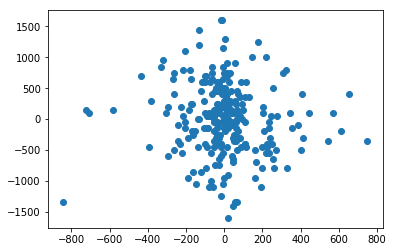

In [98]:
plt.scatter(과거비트코인변화, 다음날주가변화)

In [264]:
# 상관계수가 0에 가까우므로 둘은 상관관계가 거의 없습니다.
np.corrcoef(과거비트코인변화,다음날주가변화)
#과거,오늘
#과거,오늘

array([[ 1.        , -0.06581576],
       [-0.06581576,  1.        ]])

5. 입력X/출력Y 분리
    1. m개의 x,y쌍
    1. X(m, 60, 15) (국내증시컬럼 + 비트코인컬럼) > reshape > (m, 60*15)
    1. y(m, 30,2) > (m,30 * 2)

In [245]:
input_seq  = 90
output_seq = 30
m = len(df) - (input_seq + output_seq) + 1
len(df), m

(244, 125)

In [246]:
df = (df - df.min() ) / (df.max()-df.min()) # min_max 정규화  0..1사이로 맞춰 피팅하기 쉬워짐
x_list = []
y_list = []
for i in range(m):
    x = df.iloc[i:i+input_seq]
    y = df.iloc[i+input_seq:i+input_seq+output_seq][['종가', 'Close**']]
   # print(x.shape,y.shape)
    x_list.append(x)
    y_list.append(y)

In [247]:
len(x_list), type(x_list) #(155,60,12)
#numpy array 로  변환
x_3d = np.stack(x_list, axis=0)
y_3d = np.stack(y_list, axis=0)

x_3d.shape,y_3d.shape

((125, 90, 12), (125, 30, 2))

train/test 분리
 - test 10%

In [248]:
test_ratio = 0.1
test_m = int(len(x_3d)*test_ratio)
test_m

12

In [249]:
m = len(x_3d)
x_2d = np.reshape(x_3d,[m,-1] )
y_2d = np.reshape(y_3d,[m,-1] )

x_test = x_2d[:test_m]
x_train = x_2d[test_m:]
y_test = y_2d[:test_m]
y_train = y_2d[test_m:]

In [250]:
#model, Linear Regression, 가중치를 작게 제약시킨다 > 모든 정보를 활용해서 예측
from sklearn.linear_model import Ridge
model = Ridge(normalize=True, solver='lsqr').fit(x_train, y_train) # 2차원 이하만 가능

In [251]:
model.score(x_train,y_train), model.score(x_test, y_test)

(0.9934881525808491, -6.57486823913208)

In [252]:
recent = df.iloc[-input_seq:]
recent.shape
recent = np.reshape(np.array(recent),[1,-1])
recent.shape


(1, 1080)

In [253]:
p = model.predict(recent)
p = np.reshape(p,[output_seq,-1])
p.shape

(30, 2)

In [254]:
korea_close_index = 0
bitcoin_close_index = 9

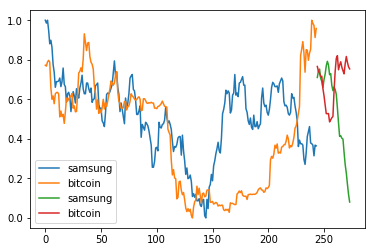

In [256]:
xm = len(df)
plt.plot(np.arange(xm), df['종가'].values, label='samsung')
plt.plot(np.arange(xm), df['Close**'].values, label='bitcoin')
plt.plot(np.arange(xm,xm+output_seq), p[:,0], label='samsung')
plt.plot(np.arange(xm,xm+output_seq), p[:,1], label='bitcoin')
plt.legend()